In [1]:
%matplotlib notebook
import numpy as np
import uncertainties
from uncertainties import ufloat
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
sns.set()

## Parámetros que se desean especificar de la simulación

Nota: las unidades utilizadas para todas las unidades son segundos y centímetros para tiempo y longitud (salvo que se indique lo contrario)

In [2]:
# Velocidad de los neutrones (E=0.025 eV)
v = 220000
# Tiempo entre reproducciones
Lambda = 100e-6
# Fracción efectiva de neutrones retardados
beta = 700e-5
# Constante de decaimiento del precursor de neutrones retardados
lam = 0.01
# Reactividad
rho = -5 * beta
# Eficiencia del detector
efi = 4e-2 

# Probabilidades de producción de neutrones instantáneos por fisión
nu_prod = np.asarray([0, 1, 2, 3, 4, 5, 6, 7])
# Probabilidad de producir nu_prod neutrones
p_prod = np.asarray([0.032, 0.17, 0.34, 0.30, 0.13, 0.027, 0.0026, 0.0002])
p_prod = p_prod/np.sum(p_prod) # re-normalización

## Magnitudes derivadas


* El factor de Diven se define cómo

\begin{equation}
D \approx D_p = \frac{\langle \nu_p (\nu_p-1)\rangle}{\langle \nu_p \rangle^2}
\end{equation}

* Sección eficáz macroscópica de fisión

\begin{equation}
\Lambda = \frac{1}{v\nu\Sigma_f} \implies \Sigma_f = \frac{1}{v\nu\Lambda}
\end{equation}

* Sección eficáz macroscópica total

\begin{equation}
k_{eff} = \frac{\nu \Sigma_f}{\Sigma_t} \implies \Sigma_t = \frac{\nu\Sigma_f}{k_{eff}}
\end{equation}

donde se toma que $\Sigma_t = \Sigma_a + \Sigma_d + \Sigma_f$ (total de capturas)

* Sección eficáz macroscópica de detección

\begin{equation}
\epsilon = \frac{\Sigma_d}{\Sigma_f} \implies \Sigma_d = \epsilon \Sigma_f
\end{equation}

In [3]:
# Factor de multiplicación
k = 1 / (1 - rho)

print("Reactividad: {} \nReactividad: {} dólares \nk: {}\n".format(rho, rho/beta, k))

# Promedio de neutrones instantáneos producidos por fisión
nu_p = np.dot(p_prod, nu_prod)
# Promedio de neutrones retardados producidos por fisión
nu_d = beta*nu_p/(1-beta)
# Total de neutrones producidos por fisión
nu = nu_p+nu_d;

print("nu_p: {:.4f} \nnu_p: {:.4f} \nnu: {:.4f}".format(nu_p, nu_d, nu))

# Factor de Diven (instantáneo, pero se asume igual al total)
D_p = np.dot(nu_prod*(nu_prod-1), p_prod) / nu_p**2

print("Factor de Diven: {:.4f}".format(D_p))
print("")

# Seccción eficáz macroscópica de fisión
Sigma_f = 1 / v / nu / Lambda
# Sección eficáz macroscópica total
Sigma_t = nu * Sigma_f / k
# Sección eficáz macroscópica de detección
Sigma_d = efi * Sigma_f
# Sección eficáz macroscópica de absorción:
Sigma_a = Sigma_t - Sigma_f - Sigma_d

print("Sigma_f: {} \nSigma_t: {} \nSigma_d: {} \nSigma_a: {}".format(Sigma_f, Sigma_t, Sigma_d, Sigma_a))
print("")

# Constante de decaimiento de los neutrones instantáneos
alfa_p = (beta - rho) / Lambda
# Constante de decaimiento de los neutrones retardados
alfa_d = lam * rho / (rho - beta)

print("alfa_p: {} \nalfa_d: {}".format(alfa_p,alfa_d))

Reactividad: -0.035 
Reactividad: -5.0 dólares 
k: 0.9661835748792271

nu_p: 2.4176 
nu_p: 0.0170 
nu: 2.4347
Factor de Diven: 0.7969

Sigma_f: 0.01866953306808798 
Sigma_t: 0.04704545454545454 
Sigma_d: 0.0007467813227235191 
Sigma_a: 0.027629140154643045

alfa_p: 420.0 
alfa_d: 0.008333333333333333


## Magnitudes asociadas con la simulación de $\alpha$-Feynman

Considerando un grupo de neutrones retardados la expresión de $\alpha$-Feynman queda:

\begin{align}
Y(\tau) &= \frac{D_p \epsilon(1-\beta)^2}{\alpha^2\Lambda^2} \left\{ f(\alpha_p\tau) + \left[ \left(\frac{\beta-\rho}{\rho}\right)^2 \left( 1 + \frac{2\beta}{(1-\beta)D_p}\right)-1\right] f(\alpha_d\tau) \right\} \\
&= Y_p f(\alpha_p\tau) + Y_d f(\alpha_d\tau)
\end{align}

donde se definió:

\begin{equation}
f(x) = 1 - \frac{1-e^{-x}}{x}
\end{equation}

junto con $\alpha = \frac{\beta-\rho}{\Lambda}$. Usualmente para reactores térmicos se satisface que $\alpha_p \approx \alpha$. Esta aproximación debe ser corroborada en la simulación donde se pueden poner valores arbitrarios a las constantes temporales. También se suale tomar $1-\beta \approx 1$.

Los valores de amplitud de cada término se pueden escribir como:

\begin{align}
Y_p &= \frac{D_p \epsilon(1-\beta)^2}{\alpha^2\Lambda^2} \\
Y_d &=  Y_p \left[ \left(\frac{\beta-\rho}{\rho}\right)^2 \left( 1 + \frac{2\beta}{(1-\beta)D_p}\right)-1\right] 
\end{align}


In [4]:
Y_p = D_p * efi * (1-beta)**2 / alfa_p**2 / Lambda**2
Y_d = Y_p * (((beta - rho) / rho)**2 * (1 + 2*beta / (1-beta/D_p) ) -1 )
print("Y_p: {} \nY_d: {}\n".format(Y_p, Y_d))

Y_p: 17.818642751287715 
Y_d: 8.20260996692269



Es interesante analizar si se puede despreciar la contribución retardada en la expresión de $\alpha$-Feynman. 

In [5]:
def _f(x):
    return 1 - (1 - np.exp(-x)) / x

def Y_afey(tau):
    _Y_p = Y_p * _f(alfa_p * tau)
    _Y_d = Y_d * _f(alfa_d * tau)
    return _Y_p + _Y_d, _Y_p, _Y_d

<IPython.core.display.Javascript object>


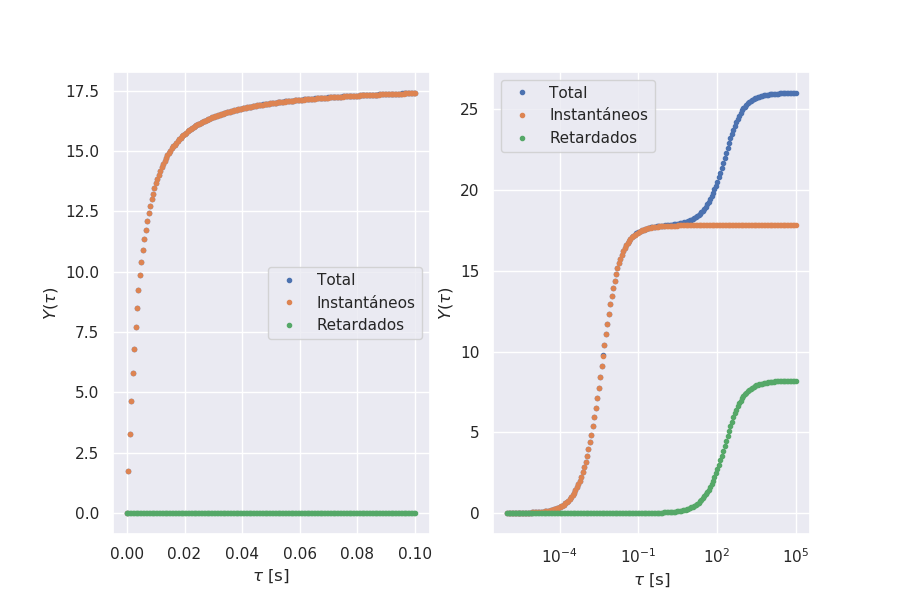

In [6]:
fig1, axes = plt.subplots(1, 2, figsize=(9,6))
tau = np.linspace(1e-6, 1e-1, 200)
tau_log = np.logspace(-6, 5, 200)

for ax, x in zip(axes, [tau, tau_log]):
    ax.plot(x, Y_afey(x)[0], '.', label='Total')
    ax.plot(x, Y_afey(x)[1], '.', label='Instantáneos')
    ax.plot(x, Y_afey(x)[2], '.', label='Retardados')
    ax.set_xlabel(r'$\tau$ [s]')
    ax.set_ylabel(r'$Y(\tau)$')
    ax.legend()
    
axes[1].set_xscale("log");

De los gráficos anteriores se puede ver que incluso hasta $\tau=0.1$ s es posible omitir el término retardado. En las mediciones de reactores térmicos se utiliza por lo general $\tau=1e-3$ s, y nunca fue necesario 

Recordar que esto se debe hacer para cada conjunto de parámetros que se especifiquen.

### Cálculo óptimo de los parámetros de la simulación

Una vez definidos la mayoría de los parámetros físicos, es necesario saber los parámetros propios de la simulación (o medición). Por ejemplo, cuánto tiempo será necesario simular para obtener una curva bien definida. 

Si bien muchas de estos parámetros van a depender de los métodos que se utilicen para obtener $Y(\tau)$, es posible hacer un análisis conservativo.

Los primcipales parámetros que quedan por definir son:

* Intensidad de la fuente de neutrones ($S$) definida como la cantidad de neutrones emitidos por unidad de tiempo
* Tiempo total de la medición ($T_{tot}$)
* Cantidad de partículas que se van a simular ($N_{nps}$)

El valor $Q$ no interviene en la fórmula de $Y(\tau)$ pero sí lo hace en su incertidumbre (a través de la tasa de detecciones).

Asumiendo que la fuente de neutrones posee una estadística Poissoniana (en la cantidad de neutrones emitidos por intervalo temporal), entonces los tres parámetros anteriores se relacionan a través de:

\begin{equation}
T_{tot} = \frac{N_{nps}}{S}
\end{equation}

### Incertezas en la determinación de $Y(\tau)$

De acuerdo a Pacilio, la incerteza relativa para la expresión de $\alpha$-Feynman, asumiendo que no existe correlación entre intervalos sucesivos de medición, se puede escribir como:

\begin{equation}
f' = \frac{\sigma_Y}{Y} = \left\{ \frac{1}{N_\tau} \left[ \left(4 + \frac{3}{\bar{n}} \right) \frac{1}{Y}  + \left( 2 + \frac{3}{\bar{n}} \right) + \frac{Y}{\bar{n}} \right]\right\}^\frac{1}{2}
\end{equation}

donde $\bar{n}$ es la tasa de cuentas detectada en el intervalo $\tau$; y $N_\tau$ son la cantidad de intervalos $\tau$ que se toman para calcular $Y(\tau)$. Si $R$ es la tasa de cuentas detectada, entonces:

\begin{equation}
\bar{n} = R \tau
\end{equation}

Usualmente, en cualquiera de la metodología escogida para obtener la curva $Y(\tau)$ conviene separar el total de la simulación/medición en *historias* o *batches*. Para cada batch se calcula la curva $Y_i(\tau)$ y luego se obtiene el promedio:

\begin{equation}
\bar{Y}(\tau) = \frac{1}{N_{batch}} \sum_{i=1}^{N_{batch}} Y_i(\tau)
\end{equation}

Y como los batches son independientes entre sí (no hay solapamiento), la incerteza para el promedio queda expresada como:

\begin{equation}
\sigma_{\bar{Y}} = \frac{1}{\sigma_Y}{\sqrt{N_{batch}}}
\end{equation}

Si además se utiliza $\bar Y$ en lugar de $Y$, la expresión para la incerteza del promedio se puede escribir como:

\begin{equation}
f = \frac{\sigma_{\bar Y}}{\bar Y} = \frac{1}{\sqrt{N_{batch}}}  \frac{\sigma_Y}{\bar Y} = \left\{ \frac{1}{N_\tau N_{batch}} \left[ \left(4 + \frac{3}{\bar{n}} \right) \frac{1}{\bar Y}  + \left( 2 + \frac{3}{\bar{n}} \right) + \frac{\bar Y}{\bar{n}} \right]\right\}^\frac{1}{2}
\end{equation}

Como para cada batch se utilizan $N_\tau$ intervalos, esta última expresión coincide con la que se obtendría de aplicar el método de $\alpha$-Feynman sin separarlo en batches. En tal caso, la cantidad total de intervalos sería $N_\tau N_{batch}$. Por este motivo, para el análisis de las incertezas se tomará $N\equiv N_\tau N_{batch}$ y se decidirá más adelante cuántos batches se utilizarán, Para esto no es necesario.

### Nota 1
El valor de $f$ será mínimo cuanto mayor sea $\bar n$, es decir, cuanto mayor la tasa de cuentas en el detector. En cambio, $f$ tiene un mínimo para un dado valor de $Y(\tau)$ (fijados el resto de los parámetros. La mínima incerteza porcentual se obtiene cuando:

\begin{equation}
Y = \sqrt{4\bar n + 3}
\end{equation}

### Nota 2

Para valores de $\bar n \ll 1$ se puede aproximar

\begin{equation}
f \approx  \left[ \frac{1}{N_\tau N_{batch}} \left(\frac{3}{\bar{n}} \frac{1}{\bar Y}  + \frac{3}{\bar{n}} + \frac{\bar Y}{\bar{n}} \right)\right]^\frac{1}{2} = \left[ \frac{1}{N_\tau N_{batch} \bar n} \left(\frac{3}{\bar Y}  + 3 + \bar Y \right)\right]^\frac{1}{2}
\end{equation}

Y entonces:

\begin{equation}
2\log(f) = -\log(N_{batch}N_\tau) -\log(\bar n) + \log\left( \frac{3}{\bar Y}  + 3 + \bar Y\right)
\end{equation}

### Nota 3

Cuando se fija el valor de $N_{nps}$ junto con el $\tau_{max}$, las magnitudes $\bar n$ y $N$ dependen sólamente de la fuente $S$ (además de los parámetros cinéticos que se los considera constantes):

\begin{align}
N &= \frac{T_{tot}}{\tau_{max}} \implies N = \frac{N_{nps}}{S\tau_{max}} \\
\bar n &= - v \Sigma_f \frac{\Lambda S}{\rho} \tau_{max}
\end{align}

Pero si $\bar n \ll 1$ (ver la Nota 2), la incerteza $f$ depende del producto $N \bar n$, y se cumple:

\begin{equation}
N \bar n = - v \Sigma_f \frac{\Lambda}{\rho} N_{nps}
\end{equation}

Es decir, la incerteza de $Y(\tau_{max})$ se vuelve independiente de $S$ y de $\tau_{max}$. EL hecho de tener una fuente muy pequeña hace que $\bar n$ sea muy pequeño, pero se compensa con el aumento en la cantidad de intervalor $N$. En la práctica esto no es demasiado útil, porque simular un tiempo muy grande trae problemas de memoria cuando se quiere procesar y construir los intervalos $\tau$ (el problema se soluciona procesando por separado las historias, en serie, para no ocupar toda la memoria al mismo tiempo).

In [7]:
def rel_uncert_Y(Y, N, n_bar):
    """
    Expresión para obtener la incerteza relativa de Y(tau)
    
    Y: Valor de Y(tau) obtenido numéricamente
    N: cantidad de intervalos $\tau$ utilizados (N=N_batch x N_tau)
    n_bar: cuentas promedio obtenidas en el intervalo tau
    """
    _rel2 = (4 + 3 / n_bar) / Y + 2 + 3 / n_bar + Y / n_bar
    return np.sqrt(_rel2 / N)


def N_point_for_f(f, Y, n_bar):
    """
    Cantidad de puntos necesarios si se quiere una incerteza de f en la curva de Y(tau)
    """
    _rel2 = (4 + 3 / n_bar) / Y + 2 + 3 / n_bar + Y / n_bar
    return np.ceil(_rel2 / f**2)


def rel_uncert_Y_for_nps(S, Y, N_nps, tau_max):
    """
    Expresión para obtener la incerteza relativa de Y(tau)
    
    Y: Valor de Y(tau) obtenido numéricamente
    N: cantidad de intervalos $\tau$ utilizados (N=N_batch x N_tau)
    n_bar: cuentas promedio obtenidas en el intervalo tau
    """
    N = N_nps / S / tau_max
    n_bar = - v * Sigma_f * Lambda * S * tau_max / rho
    _rel2 = (4 + 3 / n_bar) / Y + 2 + 3 / n_bar + Y / n_bar
    return np.sqrt(_rel2 / N)

<IPython.core.display.Javascript object>


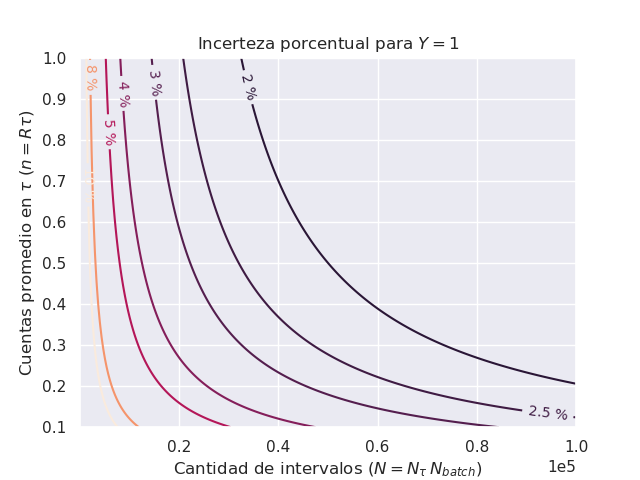

In [8]:
Y_tau = 1
N = np.linspace(10,100000, 300)
n_bar = np.linspace(.1, 1, 300)
X, Y = np.meshgrid(N, n_bar)
Z = 100 * rel_uncert_Y(Y_tau, X, Y)

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s
    
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z, levels=[1, 2, 2.5, 3, 4, 5, 8, 10])
ax.ticklabel_format(axis='x', scilimits=(0,0))
ax.set_xlabel(r"Cantidad de intervalos ($N=N_{\tau}\, N_{batch}$)")
ax.set_ylabel(r"Cuentas promedio en $\tau$ ($n=R\tau$)")
ax.set_title(r"Incerteza porcentual para $Y={}$".format(Y_tau))

# Recast levels to new class
CS.levels = [nf(val) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%%'
else:
    fmt = '%r %%'

ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10);

Esta curvas, para un dado valor de inceteza deseado, dan todas las combinaciones de $N$ y $\bar n$ posibles para un dado valor de $Y$.

En la práctica, el valor de $\bar n$ está determinado por la fuente de neutrones y por el nivel de criticidad. Por un lado se tiene que la tasa de detecciones será:

\begin{equation}
R = \epsilon F = \epsilon \lambda_f N = \epsilon v \Sigma_f N 
\end{equation}

donde la densidad neutrónica $N$ en un estado subcrítico y estacionario queda determinada por:

\begin{equation}
N = - \frac{\Lambda S}{\rho}
\end{equation}

Y como $\bar n = R \tau$:

\begin{equation}
\bar n = - \epsilon v \Sigma_f \frac{\Lambda S}{\rho} \tau
\end{equation}

In [9]:
def tasa_cuentas(S):
    """
    Tasa de cuenta para un dado valor de fuente S
    
    Se usan valores globales previamente definidos (ojo)
    """
    return -efi * v * Sigma_f * Lambda * S/ rho 

def n_tau(tau, S):
    """
    Cuentas en un intervalo tau en un estado estacionario con una fuente S
    
    Se usan valores globales previamente definidos (ojo)
    """
    return  tasa_cuentas(S) * tau

def S_tau(tau, n_bar):
    """
    VAlor de S para un dado tau y cuentas en tau
    
    Se usan valores globales previamente definidos (ojo)
    """
    return - n_bar * rho / efi / v / Sigma_f / Lambda / tau

---

### Ejemplo 1

Quiero un error relativo de 1% para el $\tau_{max}= 15\,ms$.
El resto de los parámetros son los definidos previamente.


<IPython.core.display.Javascript object>


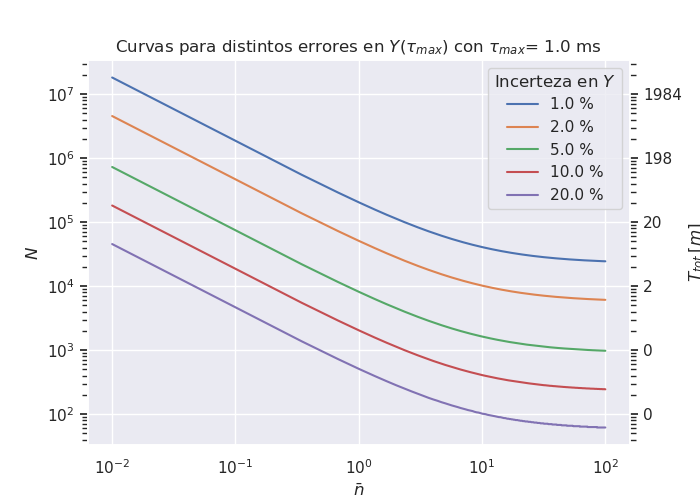

In [10]:
# Error deseado
f_obj = 0.01
# Intervalo máximo que voy a analizar
tau_max = 15e-3

# Calculo el Y(\tau_max)
Y_tau_max, _, _ = Y_afey(tau_max)

# Posibles valors de n_bar
n_bar = np.linspace(1e-2, 1e2, 300)

fig, ax = plt.subplots(1, 1, figsize=(7,5))

f_list = [0.01, 0.02, 0.05, 0.1, 0.2]

# Para comparar, grafico distintos niveles de error 
for f in f_list:
    N_val = N_point_for_f(f, Y_tau_max, n_bar)

    ax.plot(n_bar, N_val, label="{:.1f} %".format(f*100))

ax.set_xscale("log")
ax.set_xlabel(r"$\barn$")
ax.set_yscale("log")
ax.set_ylabel(r"$N$");
ax.set_title(r"Curvas para distintos errores en $Y(\tau_{{max}})$ con $\tau_{{max}}$= {} ms".format(f_obj*100, tau_max*1000))
ax.legend(title="Incerteza en $Y$")

# Como el N también me define el $T_{tot}$, lo grafico también para guiarme
ax_right = ax.twinx()
ax_right.set_ylim(ax.get_ylim())
ax_right.set_yscale("log")
formatter = mticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x*tau_max/60))
ax_right.yaxis.set_major_formatter(formatter)
ax_right.set_ylabel(r"$T_{tot}\, [m]$")
ax_right.grid(False)


Si quiero $\bar n = 1$ para un tiempo de medición aproximado de $T_{tot}=1\,h$ obtengo:

In [11]:
n_bar_buscado = 1
# Valor de la fuente
S_buscada = S_tau(tau_max, n_bar_buscado)

# La cantidad de intervalos para ese n_bar es:
N_buscado = N_point_for_f(f_obj, Y_tau_max, n_bar_buscado)
# Tiempo total de la medición
T_tot_buscado = N_buscado * tau_max

# La cantidad total de eventos de fuente que necesito simular será:
N_nps_buscado = int(np.ceil(T_tot_buscado * S_buscada))

print("Valor de la fuente: {}".format(S_buscada))
print("Tasa de detecciones: {}".format(tasa_cuentas(S_buscada)))
print("Tiempo total de la medición: {} m".format(T_tot_buscado/60))
print("Cantidad de eventos de fuente a simular: {}".format(N_nps_buscado))

Valor de la fuente: 142.02364578937505
Tasa de detecciones: 66.66666666666667
Tiempo total de la medición: 51.157000000000004 m
Cantidad de eventos de fuente a simular: 435931


---

#### Ejemplo 2

Para los mismos parámetros cinéticos (y por lo tanto el mismo $\tau_{{max}}$) ahora fijo la cantidad de eventor que voy a simular $N_{nps}$. Deseo encontrar la relación entre el valor de la fuente $S$ y el error en la determinación de $Y(\tau_{{max}})$



<IPython.core.display.Javascript object>


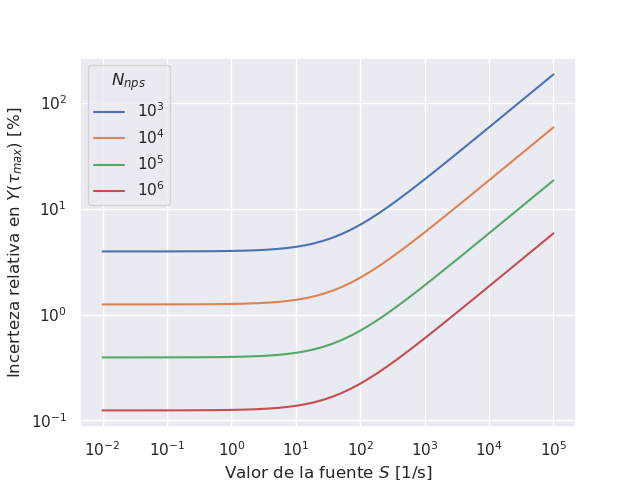

In [12]:
# Valor máximo que necesito para tener bien definida la curva Y(\tau)
tau_max = 15e-3
# Cantidad de eventos de fuente que voy a simular
N_nps_buscado = 1e5

# Calculo el Y(\tau_max)
Y_tau_max, _, _ = Y_afey(tau_max)

# Posibles valores de S
S = np.logspace(-2, 5)

N_nps_lst = [1e3, 1e4, 1e5, 1e6]

fig, ax = plt.subplots(1, 1)
# Para formatear a notación científica
_fo = mticker.ScalarFormatter(useMathText=True)
_fo.set_powerlimits((-3,3))
for nps in N_nps_lst:
    f_for_S = 100 * rel_uncert_Y_for_nps(S, Y_tau_max, nps, tau_max)
    ax.plot(S, f_for_S, label="${}$".format(_fo.format_data(nps)))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Valor de la fuente $S$ [1/s]")
ax.set_ylabel(r"Incerteza relativa en $Y(\tau_{{max}})$ [%]")

ax.legend(title=r"$N_{nps}$");

Notar el valor asintótico de $f$ para valores muy chicos de $S$, es lo que se comentó en la Nota 3.

Si tomo $S=1000$ 1/s obtengo un error relativo de f=2% (aproximadamente)

In [13]:
# Valor de fuente elegido
S_buscado = 1e3
# Incerteza relativa 
f_buscado = rel_uncert_Y_for_nps(S_buscado, Y_tau_max, nps, tau_max)
    
# El tiempo total de medición:
T_tot_buscado = nps / S_buscado
# La cantidad total de intervalos de tau_max:
N_buscado = np.floor(T_tot_buscado / tau_max)

print("Tasa de detecciones: {}".format(tasa_cuentas(S_buscada)))
print("Tiempo total de la medición: {} m".format(T_tot_buscado/60))
print(r"Cantidad de intervalos de $\tau_{{max}}: {}".format(N_buscado))



Tasa de detecciones: 66.66666666666667
Tiempo total de la medición: 16.666666666666668 m
Cantidad de intervalos de $\tau_{max}: 66666.0


---

## Posible algoritmo para definir los parámetros de la simulación / medición

1. Se definen las secciones eficaces en base a los parámetros deseados ($\Lambda$, $\rho$, $\alpha_p$, etc)
2. En base al $\alpha_p$ se determina cuál será el $\tau$ máximo ($\tau_{max}$) necesario para definir la curva de $Y(\tau)$. Uno busca que los $\tau$ contengan toda la parte relevante de la curva, por lo cual, un posible criterio es tomar:

\begin{equation}
\tau_{max} = 5 \frac{1}{\alpha_p}
\end{equation}

3. Para el valor de $\tau_{max}$ se calcula el valor $Y(\tau_{max})$
4. Con el valor de $Y(\tau_{max})$ se calculan la las posibles combinaciones de $\bar n$ y $N$ que dan la incerteza relativa deseada.
5. Entre todas las combinaciones de $\bar n$ y de $N$ se decide cuántos puntos se van a simular. 

    * Un valor de $N$ fija la cantidad de $\tau_{max}$ necesarios, y por lo tanto el tiempo total estimado para la medición pues $T_{tot} = N \tau_{max}$ (con el método de agrupamiento, es la cantidad exacta, si se utiliza mca es una cantidad mínima pues se deben tener otros $\tau$ independientes de $\tau_{max}$. Recordar que $N=N_{batch}N_
    * Un valor de $\bar n$ fija el valor de $S$
    * Ambos se relacionan con la cantidad de puntos simulados ($N_{nps}) a través de la expresión
    
    \begin{equation}
    T_{tot} = \frac{N_{nps}}{S}
    \end{equation}

6. Vemos el juego entre estos dos parámetros: lo ideal es tener $S$ grande y un $T_{tot}$ también lo más grande posible, pero eso implicaría simular mucho eventos de fuente, lo que haría extremadamente costoso (en memoria si uso el script de Octave, o en tiempo si uso MCNP).


## Pruebas rápidas sin análisis

In [14]:
# Cantidad de eventos de fuente
nps = 1e6
# Valor de la fuente [1/s]
S = 1e3

T_tot = nps / S
tau_max = 5 / alfa_p
N = np.floor(T_tot / tau_max)

print("TIempo total simulado: {:.2f} m ({} s)".format(T_tot / 60, T_tot))
print("tau_max: {:.2e} s".format(tau_max))
print("Cantidad de intervalos con tau_max: {:.0f}".format(N))

# Calculo el Y(\tau_max)
Y_tau_max, _, _ = Y_afey(tau_max)
n_bar = n_tau(tau_max, S)
f = rel_uncert_Y(Y_tau_max, N, n_bar)
print("Incerteza relativa de $Y(tau_max)$: {:.2f} %".format(f*100))

TIempo total simulado: 16.67 m (1000.0 s)
tau_max: 1.19e-02 s
Cantidad de intervalos con tau_max: 84000
Incerteza relativa de $Y(tau_max)$: 0.80 %
